# Experimento 0 : Validación del artículo "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets".

En este experimiento usaremos la infraestructura planteada para comprobar si las ideas del artículo "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets" se validan en un problema multiclase.


## Librerías usadas.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Parámetros globales

In [ ]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))



csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 50
longitud = 50
clases = 7


print(data_dir)

print(csv_path)



## Creación del marco de datos.

In [ ]:
#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

all_image_path = glob(os.path.join(data_dir, '*', '*'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(imageid_path_dict.get)
dataFrame['cell_type'] = dataFrame['dx'].map(lesion_type_dict.get) 
dataFrame['cell_type_idx'] = pd.Categorical(dataFrame['cell_type']).codes
dataFrame.head()


## Select_network

Este método permite seleccionar la parte superior de una red.

In [ ]:
def select_network(nn_base_arch):

    if nn_base_arch =='CNN_SOCO':
        nn = cnn_soco()
        
    return nn

## Los métodos que se describen acontinuación permitirán crear diferentes tipos de capas superiores que se usarán en el método select_network. Los métodos son : 

 - cnn_soco = Es una réplica de la red usada en el estudio "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets".


In [ ]:
def cnn_soco():
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1), activation='relu',input_shape=(altura,longitud,3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1),activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

 
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    print(model.summary())
    
    return model

## Los métodos que se describen a continuación generarán la capa de salida de nuestra red : 
 - build : Modificación de la anterior, añadimos una capa de BachNormalization

In [ ]:
def build(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))
  
  

    print(model.summary())

    return model

def build_dense(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation('relu'))
    
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))
  
  

    print(model.summary())

    return model

In [ ]:
nn = select_network('CNN_SOCO')
model = build(nn)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0         
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_5"
_________________________________________________________________
Layer (type)           

## Se procede a crear un método que permita balancear la carga de imágenes

In [ ]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [ ]:
del dataFrame
del imgs
del target
del x_train
del x_test
del y_train
del y_test
del x_val
del y_val

## Cargamos los datos y generamos el set de datos,entrenamiento y validación.

In [ ]:
imgs, target = load_img_data(altura, dataFrame, balanced=True)

100%|██████████| 17500/17500 [02:12<00:00, 131.75it/s]


(17500, 50, 50, 3)


###Carga de datos para transfer learning

In [ ]:
def load_data_transfer_learning(imgs, target):
    
    x_train, x_transferLearning, y_train, y_transferLearning = train_test_split(imgs, target, test_size=0.60)
    

    
    tf_data = [ x_transferLearning , y_transferLearning ]
    train_data = [ x_train , y_train ]


    
    return tf_data,train_data

In [ ]:
tf_data,train_data = load_data_transfer_learning(imgs,target)


In [ ]:
imgs = tf_data[0]
target = tf_data[1]

x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

trainX = train_val_test[0]
trainY = train_val_test[1]
valX = train_val_test[2]
valY = train_val_test[3]
testX = train_val_test[4]
testY = train_val_test[5]

numTrainingSamples = trainX.shape[0]
numValidationSamples = valX.shape[0]

### Carga de datos

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

trainX = train_val_test[0]
trainY = train_val_test[1]
valX = train_val_test[2]
valY = train_val_test[3]
testX = train_val_test[4]
testY = train_val_test[5]

numTrainingSamples = trainX.shape[0]
numValidationSamples = valX.shape[0]

### Generamos algunos parámentros adicionales para el entrenamiento

In [ ]:
mini_batch_size =numTrainingSamples/875
mbs=int(mini_batch_size)
mbs


6

In [ ]:
optAMSGrad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="AMSGrad"

)


In [ ]:

RMSpropEstudio = tf.keras.optimizers.RMSprop(
    learning_rate=0.0001
)

## Fase de entrenamiento.


In [ ]:
def run_train(nn_base_arch,checkpoint,epocas,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSpropEstudio, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,steps_per_epoch=(numTrainingSamples/(mbs*25)),epochs=epocas,validation_data=(valX, valY),callbacks=[checkpoint],batch_size = mbs)
      
    return history

def re_train(model,checkpoint,epocas):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    history = model.fit(x_train, y_train,steps_per_epoch=(numTrainingSamples/(mbs*25)),epochs=epocas,validation_data=(valX, valY),callbacks=[checkpoint],batch_size = mbs)
  
    return history

def run_train_in_model(model,checkpoint,epocas):
        
    cp = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    
    
    history = model.fit(x_train, y_train,steps_per_epoch=(numTrainingSamples/(mbs*25)),epochs=epocas,validation_data=(valX, valY),batch_size = mbs)
      
    return history

In [ ]:
epocas = 500
nn_base_arch = "CNN_SOCO"
checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_ph2_weights_EXP1_TL.h5"
history = run_train(nn_base_arch,checkpoint,epocas,dense = False)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 64)        0         
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_9"
_________________________________________________________________
Layer (type)           

Epoch 39/500
35/35 [============================>.] - ETA: 0s - loss: 1.3924 - accuracy: 0.4476 - mse: 13.0017
Epoch 00039: val_loss did not improve from 1.37930
36/35 [==============================] - 1s 32ms/step - loss: 1.3855 - accuracy: 0.4537 - mse: 13.0671 - val_loss: 1.4346 - val_accuracy: 0.4643 - val_mse: 12.7961
Epoch 40/500
36/35 [==============================] - ETA: 0s - loss: 1.3706 - accuracy: 0.4722 - mse: 12.2237
Epoch 00040: val_loss did not improve from 1.37930
36/35 [==============================] - 1s 27ms/step - loss: 1.3706 - accuracy: 0.4722 - mse: 12.2237 - val_loss: 1.4179 - val_accuracy: 0.4429 - val_mse: 12.7961
Epoch 41/500
36/35 [==============================] - ETA: 0s - loss: 1.2900 - accuracy: 0.5046 - mse: 12.8566
Epoch 00041: val_loss improved from 1.37930 to 1.34912, saving model to ../TFG/Modelos/balanced_model_CNN_SOCO_ph2_weights_EXP1_TL.h5
36/35 [==============================] - 1s 28ms/step - loss: 1.2900 - accuracy: 0.5046 - mse: 12.8566 

Epoch 87/500
36/35 [==============================] - ETA: 0s - loss: 1.2127 - accuracy: 0.5139 - mse: 13.9076
Epoch 00087: val_loss did not improve from 1.19106
36/35 [==============================] - 1s 26ms/step - loss: 1.2127 - accuracy: 0.5139 - mse: 13.9076 - val_loss: 1.2656 - val_accuracy: 0.5286 - val_mse: 12.8110
Epoch 88/500
34/35 [===========================>..] - ETA: 0s - loss: 1.1731 - accuracy: 0.5539 - mse: 11.8846
Epoch 00088: val_loss did not improve from 1.19106
36/35 [==============================] - 1s 28ms/step - loss: 1.1736 - accuracy: 0.5509 - mse: 11.9891 - val_loss: 1.2577 - val_accuracy: 0.5036 - val_mse: 12.8116
Epoch 89/500
36/35 [==============================] - ETA: 0s - loss: 1.2597 - accuracy: 0.5463 - mse: 10.8456
Epoch 00089: val_loss did not improve from 1.19106
36/35 [==============================] - 1s 27ms/step - loss: 1.2597 - accuracy: 0.5463 - mse: 10.8456 - val_loss: 1.2068 - val_accuracy: 0.5500 - val_mse: 12.8065
Epoch 90/500
34/35 [==

34/35 [===========================>..] - ETA: 0s - loss: 1.0931 - accuracy: 0.5588 - mse: 11.8538
Epoch 00134: val_loss did not improve from 1.08372
36/35 [==============================] - 1s 29ms/step - loss: 1.0916 - accuracy: 0.5602 - mse: 12.1356 - val_loss: 1.0918 - val_accuracy: 0.5821 - val_mse: 12.8180
Epoch 135/500
35/35 [============================>.] - ETA: 0s - loss: 1.0457 - accuracy: 0.5952 - mse: 11.0304
Epoch 00135: val_loss did not improve from 1.08372
36/35 [==============================] - 1s 29ms/step - loss: 1.0288 - accuracy: 0.6019 - mse: 11.0730 - val_loss: 1.2163 - val_accuracy: 0.5393 - val_mse: 12.8169
Epoch 136/500
35/35 [============================>.] - ETA: 0s - loss: 0.9319 - accuracy: 0.6429 - mse: 11.5929
Epoch 00136: val_loss did not improve from 1.08372
36/35 [==============================] - 1s 28ms/step - loss: 0.9273 - accuracy: 0.6435 - mse: 11.5517 - val_loss: 1.1140 - val_accuracy: 0.5929 - val_mse: 12.8186
Epoch 137/500
36/35 [============

Epoch 159/500
35/35 [============================>.] - ETA: 0s - loss: 0.8877 - accuracy: 0.6333 - mse: 12.3124
Epoch 00159: val_loss did not improve from 1.04591
36/35 [==============================] - 1s 32ms/step - loss: 0.8735 - accuracy: 0.6435 - mse: 12.4779 - val_loss: 1.1027 - val_accuracy: 0.6250 - val_mse: 12.8215
Epoch 160/500
35/35 [============================>.] - ETA: 0s - loss: 0.8905 - accuracy: 0.6476 - mse: 12.7754
Epoch 00160: val_loss did not improve from 1.04591
36/35 [==============================] - 1s 33ms/step - loss: 0.8889 - accuracy: 0.6481 - mse: 12.7689 - val_loss: 1.0617 - val_accuracy: 0.6071 - val_mse: 12.8191
Epoch 161/500
35/35 [============================>.] - ETA: 0s - loss: 1.0447 - accuracy: 0.6048 - mse: 12.0544
Epoch 00161: val_loss did not improve from 1.04591
36/35 [==============================] - 1s 31ms/step - loss: 1.0350 - accuracy: 0.6111 - mse: 12.0368 - val_loss: 1.0838 - val_accuracy: 0.6179 - val_mse: 12.8204
Epoch 162/500
36/35

Epoch 208/500
35/35 [============================>.] - ETA: 0s - loss: 0.8642 - accuracy: 0.7333 - mse: 11.5506
Epoch 00208: val_loss did not improve from 0.95355
36/35 [==============================] - 1s 29ms/step - loss: 0.8626 - accuracy: 0.7315 - mse: 11.4075 - val_loss: 0.9905 - val_accuracy: 0.6536 - val_mse: 12.8271
Epoch 209/500
35/35 [============================>.] - ETA: 0s - loss: 0.8493 - accuracy: 0.6857 - mse: 11.4295
Epoch 00209: val_loss did not improve from 0.95355
36/35 [==============================] - 1s 28ms/step - loss: 0.8441 - accuracy: 0.6852 - mse: 11.3769 - val_loss: 0.9976 - val_accuracy: 0.6500 - val_mse: 12.8245
Epoch 210/500
36/35 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.6991 - mse: 11.1311
Epoch 00210: val_loss did not improve from 0.95355
36/35 [==============================] - 1s 30ms/step - loss: 0.8574 - accuracy: 0.6991 - mse: 11.1311 - val_loss: 0.9881 - val_accuracy: 0.6357 - val_mse: 12.8247
Epoch 211/500
34/35

35/35 [============================>.] - ETA: 0s - loss: 0.7048 - accuracy: 0.7143 - mse: 13.2217
Epoch 00232: val_loss did not improve from 0.93968
36/35 [==============================] - 1s 28ms/step - loss: 0.6928 - accuracy: 0.7222 - mse: 13.2011 - val_loss: 0.9930 - val_accuracy: 0.6786 - val_mse: 12.8345
Epoch 233/500
36/35 [==============================] - ETA: 0s - loss: 0.8006 - accuracy: 0.6991 - mse: 12.3380
Epoch 00233: val_loss did not improve from 0.93968
36/35 [==============================] - 1s 26ms/step - loss: 0.8006 - accuracy: 0.6991 - mse: 12.3380 - val_loss: 0.9576 - val_accuracy: 0.6607 - val_mse: 12.8312
Epoch 234/500
34/35 [===========================>..] - ETA: 0s - loss: 0.8579 - accuracy: 0.6863 - mse: 11.0107
Epoch 00234: val_loss did not improve from 0.93968
36/35 [==============================] - 1s 26ms/step - loss: 0.8614 - accuracy: 0.6806 - mse: 10.9630 - val_loss: 0.9555 - val_accuracy: 0.6643 - val_mse: 12.8283
Epoch 235/500
34/35 [============

Epoch 256/500
34/35 [===========================>..] - ETA: 0s - loss: 0.7752 - accuracy: 0.7402 - mse: 11.1567
Epoch 00256: val_loss did not improve from 0.88615
36/35 [==============================] - 1s 26ms/step - loss: 0.8043 - accuracy: 0.7269 - mse: 11.1662 - val_loss: 0.9925 - val_accuracy: 0.6607 - val_mse: 12.8361
Epoch 257/500
34/35 [===========================>..] - ETA: 0s - loss: 0.7346 - accuracy: 0.7500 - mse: 11.6469
Epoch 00257: val_loss did not improve from 0.88615
36/35 [==============================] - 1s 27ms/step - loss: 0.7432 - accuracy: 0.7500 - mse: 11.7010 - val_loss: 0.8865 - val_accuracy: 0.6893 - val_mse: 12.8324
Epoch 258/500
34/35 [===========================>..] - ETA: 0s - loss: 0.8183 - accuracy: 0.7647 - mse: 11.9611
Epoch 00258: val_loss improved from 0.88615 to 0.88199, saving model to ../TFG/Modelos/balanced_model_CNN_SOCO_ph2_weights_EXP1_TL.h5
36/35 [==============================] - 1s 29ms/step - loss: 0.8113 - accuracy: 0.7593 - mse: 12.05

34/35 [===========================>..] - ETA: 0s - loss: 0.7098 - accuracy: 0.7402 - mse: 10.7243
Epoch 00280: val_loss improved from 0.84674 to 0.84322, saving model to ../TFG/Modelos/balanced_model_CNN_SOCO_ph2_weights_EXP1_TL.h5
36/35 [==============================] - 1s 28ms/step - loss: 0.6970 - accuracy: 0.7407 - mse: 10.8291 - val_loss: 0.8432 - val_accuracy: 0.6857 - val_mse: 12.8341
Epoch 281/500
34/35 [===========================>..] - ETA: 0s - loss: 0.6479 - accuracy: 0.7549 - mse: 12.3923
Epoch 00281: val_loss did not improve from 0.84322
36/35 [==============================] - 1s 30ms/step - loss: 0.6576 - accuracy: 0.7546 - mse: 12.1752 - val_loss: 0.8872 - val_accuracy: 0.6929 - val_mse: 12.8355
Epoch 282/500
35/35 [============================>.] - ETA: 0s - loss: 0.6278 - accuracy: 0.7667 - mse: 12.4945
Epoch 00282: val_loss did not improve from 0.84322
36/35 [==============================] - 1s 27ms/step - loss: 0.6349 - accuracy: 0.7639 - mse: 12.4684 - val_loss:

36/35 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.7685 - mse: 12.0622
Epoch 00328: val_loss did not improve from 0.76975
36/35 [==============================] - 1s 32ms/step - loss: 0.6741 - accuracy: 0.7685 - mse: 12.0622 - val_loss: 0.7950 - val_accuracy: 0.7107 - val_mse: 12.8361
Epoch 329/500
35/35 [============================>.] - ETA: 0s - loss: 0.6289 - accuracy: 0.7810 - mse: 10.5470
Epoch 00329: val_loss did not improve from 0.76975
36/35 [==============================] - 1s 30ms/step - loss: 0.6261 - accuracy: 0.7824 - mse: 10.7055 - val_loss: 0.7797 - val_accuracy: 0.7107 - val_mse: 12.8415
Epoch 330/500
35/35 [============================>.] - ETA: 0s - loss: 0.8030 - accuracy: 0.7238 - mse: 11.3149
Epoch 00330: val_loss did not improve from 0.76975
36/35 [==============================] - 1s 32ms/step - loss: 0.7976 - accuracy: 0.7222 - mse: 11.3972 - val_loss: 0.8021 - val_accuracy: 0.7500 - val_mse: 12.8353
Epoch 331/500
35/35 [============

Epoch 377/500
34/35 [===========================>..] - ETA: 0s - loss: 0.4393 - accuracy: 0.8382 - mse: 13.1243
Epoch 00377: val_loss did not improve from 0.70776
36/35 [==============================] - 1s 31ms/step - loss: 0.4647 - accuracy: 0.8287 - mse: 12.9380 - val_loss: 0.7369 - val_accuracy: 0.7214 - val_mse: 12.8455
Epoch 378/500
34/35 [===========================>..] - ETA: 0s - loss: 0.5992 - accuracy: 0.7990 - mse: 10.8972
Epoch 00378: val_loss did not improve from 0.70776
36/35 [==============================] - 1s 28ms/step - loss: 0.5979 - accuracy: 0.7963 - mse: 10.8947 - val_loss: 0.7733 - val_accuracy: 0.7286 - val_mse: 12.8455
Epoch 379/500
36/35 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8472 - mse: 10.4722
Epoch 00379: val_loss did not improve from 0.70776
36/35 [==============================] - 1s 26ms/step - loss: 0.4729 - accuracy: 0.8472 - mse: 10.4722 - val_loss: 0.7370 - val_accuracy: 0.7393 - val_mse: 12.8447
Epoch 380/500
34/35

Epoch 402/500
36/35 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.7963 - mse: 12.7072
Epoch 00402: val_loss did not improve from 0.68967
36/35 [==============================] - 1s 28ms/step - loss: 0.5411 - accuracy: 0.7963 - mse: 12.7072 - val_loss: 0.6998 - val_accuracy: 0.7750 - val_mse: 12.8494
Epoch 403/500
34/35 [===========================>..] - ETA: 0s - loss: 0.4998 - accuracy: 0.8137 - mse: 11.2786
Epoch 00403: val_loss did not improve from 0.68967
36/35 [==============================] - 1s 26ms/step - loss: 0.4834 - accuracy: 0.8194 - mse: 11.3115 - val_loss: 0.7121 - val_accuracy: 0.7357 - val_mse: 12.8452
Epoch 404/500
34/35 [===========================>..] - ETA: 0s - loss: 0.4569 - accuracy: 0.8578 - mse: 12.1395
Epoch 00404: val_loss did not improve from 0.68967
36/35 [==============================] - 1s 27ms/step - loss: 0.4637 - accuracy: 0.8565 - mse: 11.9025 - val_loss: 0.7499 - val_accuracy: 0.7179 - val_mse: 12.8495
Epoch 405/500
34/35

Epoch 427/500
36/35 [==============================] - ETA: 0s - loss: 0.4425 - accuracy: 0.8750 - mse: 11.3806
Epoch 00427: val_loss did not improve from 0.66809
36/35 [==============================] - 1s 32ms/step - loss: 0.4425 - accuracy: 0.8750 - mse: 11.3806 - val_loss: 0.6960 - val_accuracy: 0.7821 - val_mse: 12.8504
Epoch 428/500
35/35 [============================>.] - ETA: 0s - loss: 0.4493 - accuracy: 0.8429 - mse: 12.8520
Epoch 00428: val_loss did not improve from 0.66809
36/35 [==============================] - 1s 30ms/step - loss: 0.4452 - accuracy: 0.8426 - mse: 13.0315 - val_loss: 0.7674 - val_accuracy: 0.7536 - val_mse: 12.8488
Epoch 429/500
36/35 [==============================] - ETA: 0s - loss: 0.4339 - accuracy: 0.8519 - mse: 10.8373
Epoch 00429: val_loss did not improve from 0.66809
36/35 [==============================] - 1s 28ms/step - loss: 0.4339 - accuracy: 0.8519 - mse: 10.8373 - val_loss: 0.7971 - val_accuracy: 0.7321 - val_mse: 12.8430
Epoch 430/500
36/35

Epoch 452/500
34/35 [===========================>..] - ETA: 0s - loss: 0.3762 - accuracy: 0.8824 - mse: 13.2883
Epoch 00452: val_loss did not improve from 0.66367
36/35 [==============================] - 1s 28ms/step - loss: 0.3873 - accuracy: 0.8750 - mse: 13.6971 - val_loss: 0.7000 - val_accuracy: 0.7714 - val_mse: 12.8538
Epoch 453/500
34/35 [===========================>..] - ETA: 0s - loss: 0.3789 - accuracy: 0.8480 - mse: 11.9430
Epoch 00453: val_loss did not improve from 0.66367
36/35 [==============================] - 1s 26ms/step - loss: 0.3840 - accuracy: 0.8472 - mse: 11.7887 - val_loss: 0.7495 - val_accuracy: 0.7536 - val_mse: 12.8546
Epoch 454/500
36/35 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8426 - mse: 12.3032
Epoch 00454: val_loss did not improve from 0.66367
36/35 [==============================] - 1s 27ms/step - loss: 0.4312 - accuracy: 0.8426 - mse: 12.3032 - val_loss: 0.6679 - val_accuracy: 0.7679 - val_mse: 12.8493
Epoch 455/500
34/35

In [ ]:
nn_base_arch = "CNN_SOCO"
checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_ph2_weights_EXP1_TL.h5"

In [ ]:
tf_model = tf.keras.models.load_model(checkpoint)

tf_model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSpropEstudio, metrics=['accuracy'])


In [ ]:
layer = tf_model.layers[0]
layer.trainable = False


In [ ]:
nn_base_arch = "CNN_SOCO"
checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_ph1_weights_EXP1_TL_Trained_02.h5"

In [ ]:
model = run_train_in_model(tf_model,checkpoint,400)

Epoch 1/400
54/53 [==============================] - 2s 28ms/step - loss: 0.6538 - accuracy: 0.8611 - val_loss: 1.0711 - val_accuracy: 0.7929
Epoch 2/400
54/53 [==============================] - 2s 33ms/step - loss: 0.6599 - accuracy: 0.8580 - val_loss: 0.8089 - val_accuracy: 0.8333
Epoch 3/400
54/53 [==============================] - 2s 32ms/step - loss: 0.6501 - accuracy: 0.8302 - val_loss: 0.8672 - val_accuracy: 0.7929
Epoch 4/400
54/53 [==============================] - 2s 34ms/step - loss: 0.5217 - accuracy: 0.8457 - val_loss: 0.7216 - val_accuracy: 0.8500
Epoch 5/400
54/53 [==============================] - 2s 28ms/step - loss: 0.6818 - accuracy: 0.8395 - val_loss: 0.7491 - val_accuracy: 0.8119
Epoch 6/400
54/53 [==============================] - 2s 31ms/step - loss: 0.5225 - accuracy: 0.8426 - val_loss: 0.7692 - val_accuracy: 0.8071
Epoch 7/400
54/53 [==============================] - 2s 29ms/step - loss: 0.5955 - accuracy: 0.8488 - val_loss: 0.6545 - val_accuracy: 0.8548
Epoch 

54/53 [==============================] - 1s 27ms/step - loss: 0.2038 - accuracy: 0.9383 - val_loss: 0.4313 - val_accuracy: 0.8595
Epoch 116/400
54/53 [==============================] - 1s 27ms/step - loss: 0.3523 - accuracy: 0.8858 - val_loss: 0.3524 - val_accuracy: 0.8857
Epoch 117/400
54/53 [==============================] - 1s 26ms/step - loss: 0.2968 - accuracy: 0.8951 - val_loss: 0.3879 - val_accuracy: 0.8762
Epoch 118/400
54/53 [==============================] - 1s 26ms/step - loss: 0.2808 - accuracy: 0.8951 - val_loss: 0.4184 - val_accuracy: 0.8571
Epoch 119/400
54/53 [==============================] - 2s 29ms/step - loss: 0.3526 - accuracy: 0.9012 - val_loss: 0.3602 - val_accuracy: 0.8786
Epoch 120/400
54/53 [==============================] - 1s 27ms/step - loss: 0.2619 - accuracy: 0.9105 - val_loss: 0.4312 - val_accuracy: 0.8571
Epoch 121/400
54/53 [==============================] - 1s 26ms/step - loss: 0.2872 - accuracy: 0.9043 - val_loss: 0.4943 - val_accuracy: 0.8452
Epoch 

Epoch 172/400
54/53 [==============================] - 1s 28ms/step - loss: 0.2060 - accuracy: 0.9259 - val_loss: 0.3443 - val_accuracy: 0.8833
Epoch 173/400
54/53 [==============================] - 2s 28ms/step - loss: 0.1455 - accuracy: 0.9475 - val_loss: 0.3553 - val_accuracy: 0.8881
Epoch 174/400
54/53 [==============================] - 2s 28ms/step - loss: 0.1401 - accuracy: 0.9506 - val_loss: 0.3468 - val_accuracy: 0.8929
Epoch 175/400
54/53 [==============================] - 2s 33ms/step - loss: 0.2349 - accuracy: 0.9198 - val_loss: 0.3547 - val_accuracy: 0.8810
Epoch 176/400
54/53 [==============================] - 2s 32ms/step - loss: 0.2130 - accuracy: 0.9259 - val_loss: 0.3287 - val_accuracy: 0.8929
Epoch 177/400
54/53 [==============================] - 2s 31ms/step - loss: 0.1887 - accuracy: 0.9475 - val_loss: 0.3201 - val_accuracy: 0.9071
Epoch 178/400
54/53 [==============================] - 1s 27ms/step - loss: 0.1705 - accuracy: 0.9506 - val_loss: 0.3475 - val_accuracy:

Epoch 229/400
54/53 [==============================] - 2s 28ms/step - loss: 0.1565 - accuracy: 0.9414 - val_loss: 0.3209 - val_accuracy: 0.8857
Epoch 230/400
54/53 [==============================] - 1s 27ms/step - loss: 0.1100 - accuracy: 0.9630 - val_loss: 0.3580 - val_accuracy: 0.8857
Epoch 231/400
54/53 [==============================] - 2s 33ms/step - loss: 0.1361 - accuracy: 0.9506 - val_loss: 0.4197 - val_accuracy: 0.8690
Epoch 232/400
54/53 [==============================] - 2s 31ms/step - loss: 0.1894 - accuracy: 0.9383 - val_loss: 0.4394 - val_accuracy: 0.8619
Epoch 233/400
54/53 [==============================] - 2s 33ms/step - loss: 0.1545 - accuracy: 0.9506 - val_loss: 0.3048 - val_accuracy: 0.9119
Epoch 234/400
54/53 [==============================] - 2s 35ms/step - loss: 0.1176 - accuracy: 0.9568 - val_loss: 0.2995 - val_accuracy: 0.9095
Epoch 235/400
54/53 [==============================] - 2s 29ms/step - loss: 0.1486 - accuracy: 0.9506 - val_loss: 0.3466 - val_accuracy:

Epoch 286/400
54/53 [==============================] - 1s 26ms/step - loss: 0.1496 - accuracy: 0.9383 - val_loss: 0.3706 - val_accuracy: 0.8786
Epoch 287/400
54/53 [==============================] - 1s 26ms/step - loss: 0.0726 - accuracy: 0.9753 - val_loss: 0.4434 - val_accuracy: 0.8643
Epoch 288/400
54/53 [==============================] - 2s 33ms/step - loss: 0.1331 - accuracy: 0.9537 - val_loss: 0.3344 - val_accuracy: 0.9071
Epoch 289/400
54/53 [==============================] - 1s 27ms/step - loss: 0.1525 - accuracy: 0.9506 - val_loss: 0.3740 - val_accuracy: 0.9024
Epoch 290/400
54/53 [==============================] - 1s 26ms/step - loss: 0.1294 - accuracy: 0.9691 - val_loss: 0.3505 - val_accuracy: 0.8762
Epoch 291/400
54/53 [==============================] - 2s 32ms/step - loss: 0.1437 - accuracy: 0.9568 - val_loss: 0.4095 - val_accuracy: 0.8619
Epoch 292/400
54/53 [==============================] - 1s 27ms/step - loss: 0.1495 - accuracy: 0.9444 - val_loss: 0.3258 - val_accuracy:

Epoch 343/400
54/53 [==============================] - 2s 32ms/step - loss: 0.1342 - accuracy: 0.9568 - val_loss: 0.4125 - val_accuracy: 0.8690
Epoch 344/400
54/53 [==============================] - 2s 28ms/step - loss: 0.0831 - accuracy: 0.9753 - val_loss: 0.2842 - val_accuracy: 0.9143
Epoch 345/400
54/53 [==============================] - 1s 26ms/step - loss: 0.0907 - accuracy: 0.9691 - val_loss: 0.2995 - val_accuracy: 0.9119
Epoch 346/400
54/53 [==============================] - 1s 26ms/step - loss: 0.0994 - accuracy: 0.9630 - val_loss: 0.3383 - val_accuracy: 0.8952
Epoch 347/400
54/53 [==============================] - 1s 26ms/step - loss: 0.0538 - accuracy: 0.9846 - val_loss: 0.3930 - val_accuracy: 0.8810
Epoch 348/400
54/53 [==============================] - 2s 33ms/step - loss: 0.0622 - accuracy: 0.9722 - val_loss: 0.3646 - val_accuracy: 0.8976
Epoch 349/400
54/53 [==============================] - 2s 28ms/step - loss: 0.0788 - accuracy: 0.9784 - val_loss: 0.3215 - val_accuracy:

Epoch 400/400
54/53 [==============================] - 2s 28ms/step - loss: 0.1025 - accuracy: 0.9599 - val_loss: 0.3192 - val_accuracy: 0.9214


In [ ]:
def plot_loss(history,epochs,name):
  print('\n\n')     
  plt.figure(figsize=(12,8))
  plt.plot(np.arange(0, epochs), history.history["loss"][0:epochs], label="train_loss")
  plt.plot(np.arange(0, epochs), history.history["val_loss"][0:epochs], label="val_loss")
  plt.plot(np.arange(0, epochs), history.history["accuracy"][0:epochs], label="train_acc")
  plt.plot(np.arange(0, epochs), history.history["val_accuracy"][0:epochs], label="val_acc")
  plt.title("Training Loss and Accuracy - {}".format(name))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

ValueError: x and y must have same first dimension, but have shapes (500,) and (400,)

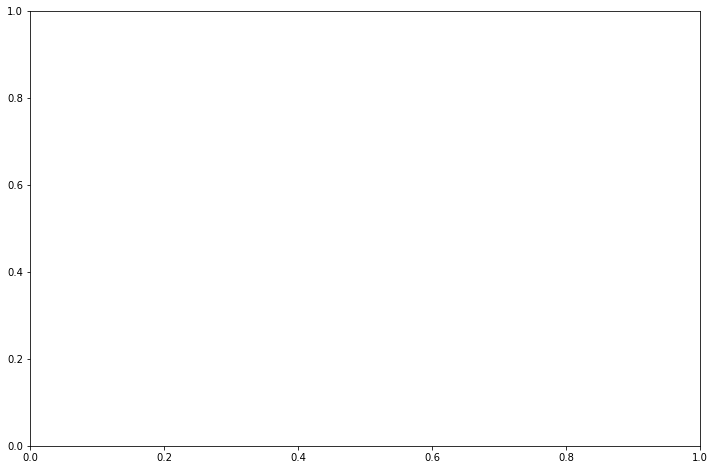

In [ ]:
plot_loss(model,epocas,nn_base_arch)

## Evaluación con el subconjunto de test.

In [ ]:
test_eval = model.model.evaluate(x_test, y_test)

66/66 [==============================] - 1s 14ms/step - loss: 0.2542 - accuracy: 0.9333
